In [3]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
import tensorflow as tf
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input, Concatenate, BatchNormalization
from tensorflow.keras import regularizers
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Descargar la lista de stopwords si no está ya descargada
nltk.download('stopwords')

# Cargar las stopwords en español
spanish_stopwords = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lingf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
train = Loader.load_train()

In [5]:
descriptions = [col for col in train.columns if "description" in col]

print(descriptions)

def custom_concat(row, cols):
    # Construir la descripción con lógica condicional basada en el valor de la celda
    parts = []
    for col_name in cols:  # Cambio para iterar solo sobre las columnas especificadas
        if col_name in row.index:  # Verificar que el nombre de la columna esté en el DataFrame
            value = row[col_name]
            if value == "no tiene" or not isinstance(value, str):
                parts.append(f"no tiene {col_name}")
            else:
                parts.append(str(value))  # Convertir a string para evitar problemas al unir
    # Unir todas las partes con espacios
    return ' '.join(parts)

# Aplicar la función al DataFrame
train['full_description'] = train.apply(custom_concat, axis=1, args=(descriptions,))
#train[descriptions].apply(lambda col: col.apply(lambda x: type(x).__name__).value_counts())

#descriptions.append("idx")
#descriptions.append("price")
#descriptions.append("km")

['motor_description', 'transmission_description', 'parking_sensors_description', 'Exterior_Llantas_description', 'Exterior_Molduras_description', 'Exterior_Neumáticos_description', 'Exterior_Puerta_description', 'Exterior_Retrovisor_description', 'Confort_Volante_description', 'seat_description', 'head_supporter_description']


In [6]:
filtered_columns = ["idx", "price", "km", "fuelType", "full_description"]
train = train[filtered_columns]
train["price_per_kilometer"] = train["price"]/train["km"]
train.dropna(inplace=True)
train

,idx,price,km,fuelType,full_description,price_per_kilometer
0,105953,22490,68887.0,Gasolina,"Motor de 1,3 litros ( 1.332 cc ) , cuatro cili...",0.326477
1,15683,19990,116892.0,Diésel,"Motor de 2,0 litros ( 1.969 cc ) , cuatro cili...",0.171013
2,153684,17500,130820.0,Diésel,"Motor de 1,6 litros ( 1.560 cc ) , cuatro cili...",0.133772
3,156928,22900,50773.0,Híbrido,"Motor de 1,8 litros ( 1.798 cc ) , cuatro cili...",0.451027
4,24443,4000,269000.0,Diésel,"Motor de 1,9 litros ( 1.910 cc ) , 4 cilindros...",0.014870
...,...,...,...,...,...,...
115592,19845,22900,77653.0,Diésel,"Motor de 1,6 litros ( 1.598 cc ) , cuatro cili...",0.294902
115593,102652,4995,157000.0,Gasolina,"Motor de 2,0 litros ( 1.997 cc ) , 4 cilindros...",0.031815
115594,101658,17490,129000.0,Gas natural (CNG),"Motor de 1,4 litros ( 1.395 cc ) , cuatro cili...",0.135581
115595,69350,19850,151560.0,Diésel,"Motor de 2,2 litros ( 2.191 cc ) , cuatro cili...",0.130971


In [7]:
#Parameters
verb_size = 200

In [8]:
def preprocess_text(text):
    # Convertir a minúsculas y eliminar caracteres especiales (pero mantener los números)
    text = text.lower()
    text = re.sub(r'[^\w\s\d]', '', text)  # Eliminar signos de puntuación, pero mantener números
    tokens = text.split()
    
    # Filtrar tokens, eliminando las stopwords
    filtered_tokens = [token for token in tokens if token not in spanish_stopwords]
    
    return filtered_tokens

train['tokens'] = train['full_description'].apply(preprocess_text)
model_w2v = Word2Vec(sentences=train['tokens'], vector_size=verb_size, window=1, min_count=3, workers=8)
word_vectors = model_w2v.wv

def get_average_embedding(tokens, model):
    embeddings = [model[word] for word in tokens if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size) 
train['embedding'] = train['tokens'].apply(lambda x: get_average_embedding(x, word_vectors))

In [9]:
train_df, test_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train['fuelType'])
train_df.head()

,idx,price,km,fuelType,full_description,price_per_kilometer,tokens,embedding
2242,92306,13900,32306.0,Híbrido,"Motor de 1,0 litros ( 999 cc ) , tres cilindro...",0.430261,"[motor, 10, litros, 999, cc, tres, cilindros, ...","[-0.1154275, -0.079180166, -0.25055006, 0.2049..."
27893,87882,5250,209000.0,Diésel,"Motor de 2 litros ( 1.991 cc ) , 4 cilindros e...",0.025120,"[motor, 2, litros, 1991, cc, 4, cilindros, lín...","[-0.21840112, -0.05413697, -0.29629067, 0.2747..."
87329,83668,32890,15077.0,Híbrido enchufable,"Motor de 2,5 litros ( 2.488 cc ) , cuatro cili...",2.181468,"[motor, 25, litros, 2488, cc, cuatro, cilindro...","[-0.16120847, 0.023253325, -0.17932121, 0.3331..."
37341,79319,34900,76225.0,Diésel,"Motor de 2,0 litros ( 1.995 cc ) , cuatro cili...",0.457855,"[motor, 20, litros, 1995, cc, cuatro, cilindro...","[-0.04928341, -0.076261364, -0.1715286, 0.2411..."
83683,89910,18960,80671.0,Híbrido enchufable,"Motor de 1,6 litros ( 1.580 cc ) , cuatro cili...",0.235029,"[motor, 16, litros, 1580, cc, cuatro, cilindro...","[-0.17213777, -0.011469802, -0.23759061, 0.282..."


In [10]:
def custom_loss(y_true, y_pred):
    # Penalizar mas los valores negativos
    loss = tf.where(y_pred < 0, tf.square(y_pred - y_true) * 10, tf.square(y_pred - y_true))
    return tf.reduce_mean(loss)

In [11]:

x_embeddings = np.stack(train_df["embedding"].values)

x_km = train_df['km'].to_numpy().reshape(-1, 1)


y = train_df['price'].to_numpy()

scaler_embeddings = StandardScaler()
x_embeddings_scaled  = scaler_embeddings.fit_transform(x_embeddings)

scaler_km = StandardScaler()
x_km_scaled = scaler_km.fit_transform(x_km)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [12]:
print('Valores NaN en x_embeddings:', np.isnan(x_embeddings).any())
print('Valores Inf en x_embeddings:', np.isinf(x_embeddings).any())
print('Valores NaN en x_km:', np.isnan(x_km).any())
print('Valores Inf en x_km:', np.isinf(x_km).any())
print('Valores NaN en y:', np.isnan(y).any())
print('Valores Inf en y:', np.isinf(y).any())

Valores NaN en x_embeddings: False
Valores Inf en x_embeddings: False
Valores NaN en x_km: False
Valores Inf en x_km: False
Valores NaN en y: False
Valores Inf en y: False


In [13]:
input_embeddings = Input(shape=(200,), name='embeddings_input')
input_km = Input(shape=(1,), name='km_input')

In [14]:
x = Dense(200, activation='relu')(input_embeddings)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

In [15]:
# Procesamiento de 'km'
km_processed = Dense(32, activation='relu')(input_km)

# Combinar
combined = tf.keras.layers.Concatenate()([x, km_processed])

In [16]:
z = Dense(16, activation='softplus')(combined)
z = tf.keras.layers.BatchNormalization()(z)
z = Dense(1)(z)  # Capa de salida

In [17]:
model = Model(inputs=[input_embeddings, input_km], outputs=z)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [19]:
print("COMIENZA EL ENTRENAMIENTO...")
history = model.fit(
    [x_embeddings_scaled, x_km_scaled],
    y_scaled,
    epochs=200,
    batch_size=32,
    verbose=True
)
print("TERMINA EL ENTRENAMIENTO...")

COMIENZA EL ENTRENAMIENTO...
Epoch 1/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 4s 842us/step - loss: 0.3752
Epoch 2/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 834us/step - loss: 0.2283
Epoch 3/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 798us/step - loss: 0.1815
Epoch 4/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 776us/step - loss: 0.1774
Epoch 5/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 782us/step - loss: 0.1735
Epoch 6/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 783us/step - loss: 0.1598
Epoch 7/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 779us/step - loss: 0.1473
Epoch 8/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 775us/step - loss: 0.1338
Epoch 9/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 784us/step - loss: 0.1364
Epoch 10/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 782us/step - loss: 0.1464
Epoch 11/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 779us/step - loss: 0.1172
Epoch 12/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 782us/step - loss: 0.1308
Epoch 13/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 837us/step - loss: 0.1172
Epoch 14/200
2760/2760 ━━━━━━━━

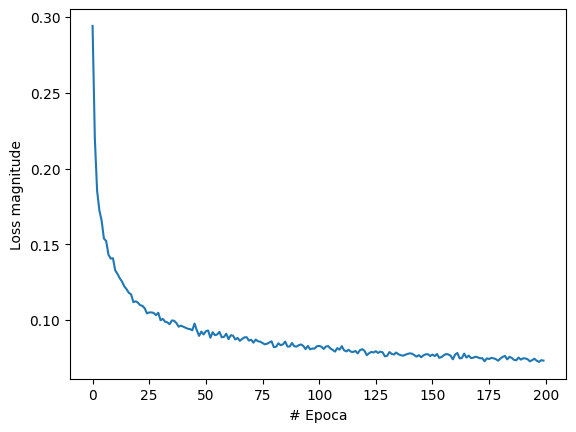

In [20]:
plt.xlabel("# Epoca")
plt.ylabel("Loss magnitude")
plt.plot(history.history["loss"])

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embeddings_input    │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200)       │     40,200 │ embeddings_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200)       │        800 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     12,864 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ km_input            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │         64 │ km_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │      1,552 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         17 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 166,333 (649.74 KB)

 Trainable params: 55,257 (215.85 KB)

 Non-trainable params: 560 (2.19 KB)

 Optimizer params: 110,516 (431.71 KB)

In [22]:
# Escalar los nuevos embeddings
new_embeddings_scaled = scaler_embeddings.transform(np.stack(test_df["embedding"].values))

# Escalar los nuevos 'km'
new_km_scaled = scaler_km.transform(test_df['km'].to_numpy().reshape(-1, 1))

print('Forma de new_embeddings_scaled:', new_embeddings_scaled.shape)
print('Forma de new_km_scaled:', new_km_scaled.shape)

Forma de new_embeddings_scaled: (22079, 200)
Forma de new_km_scaled: (22079, 1)


In [23]:
prediction = model.predict( 
            [
                new_embeddings_scaled, 
                new_km_scaled
            ] 
        ).flatten()

prediction = scaler_y.inverse_transform(prediction.reshape(-1, 1)).flatten()
realPrice = test_df['price'].to_numpy()

print('Forma de prediction:', prediction.shape)

print('Forma de price:', realPrice.shape)

690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step
Forma de prediction: (22079,)
Forma de price: (22079,)


In [24]:
result = pd.DataFrame({'Prediction': prediction, 'Real price': realPrice})

diff = np.mean(abs( (realPrice - prediction)/realPrice ))
print(result)
print("Hay un MAPE de " + str(diff) + "%")
plt.show()

         Prediction  Real price
0      46703.214844       46900
1      29810.687500       29999
2      19149.992188       20795
3      22883.789062       24460
4      21638.931641       21900
...             ...         ...
22074  14314.661133       14462
22075  23698.666016       26490
22076  25759.332031       22900
22077  45860.210938       47900
22078  43726.632812       42920

[22079 rows x 2 columns]
Hay un MAPE de 0.14052476458457816%


In [25]:
model.save('models/model_2_text_km_to_price.keras')